In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import integrate, signal, stats, fftpack
from glob import glob
import time

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events, get_evoked_traces, get_evoked_firing_rates, find_nearest_ind
)
from tbd_eeg.tbd_eeg.data_analysis.eeg_preprocessing import qualitycheck_trials

In [5]:
from PCIst.PCIst.pci_st import calc_PCIst

In [6]:
%matplotlib notebook

## Functions

In [7]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

In [8]:
def lowpass_filt_design(len_signal, sample_rate, cutoff_freq=200, trans_width=0.2, order_multiple=11, plot_kern=False):
    hz = np.linspace(0, sample_rate/2, int(np.floor(len_signal/2)+1))

    ## determine order
    order = np.round(order_multiple * sample_rate / cutoff_freq) + 1
    if order%2 == 0:
        order += 1 # order must be odd for signal.firls

    shape = [1,1,0,0]
    frex = [0, cutoff_freq, cutoff_freq*(1+trans_width), sample_rate/2]

    # filter kernel
    filtkern = signal.firls(order, frex, shape, fs=sample_rate)

    if plot_kern:
        # its power spectrum
        filtkernX = np.abs(fftpack.fft(filtkern, len_signal))**2

        fig, axs = plt.subplots(1, 2)
        axs[0].plot(np.arange(-order/2, order/2)/sample_rate, filtkern, 'k')
        axs[0].set_xlabel('Time (s)')
        axs[0].set_title('Filter kernel')

        axs[1].plot(np.array(frex), shape, 'r')
        axs[1].plot(hz, filtkernX[:len(hz)], 'k')
        axs[1].set_xlim([0, cutoff_freq*(1+trans_width) + 50])
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel('Gain')
        axs[1].set_title('Filter kernel spectrum')
        plt.show()
    
    return filtkern

#### Plot electrodes

## Load experiment instance

In [9]:
dfolder = r'T:\zap-n-zip\EEG_exp\mouse586466\estim_vis_2021-07-29_10-37-41\experiment1\recording1'
# load experiment metadata and eeg data
exp = EEGexp(dfolder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.


In [10]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse'+exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)
    
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

estim_vis


### Load EEG data and adjusted stimulus log

In [11]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_chs = np.arange(0, eeg_data.shape[1])

In [12]:
bad_chs = [1,3,4,5,7,8,9,10,11,12,13,14,28]
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [13]:
stim_log = pd.read_csv(exp.stimulus_log_file)
if 'good' not in stim_log.columns:
    qualitycheck_trials(exp, known_bad_chs=bad_chs)
    stim_log = pd.read_csv(exp.stimulus_log_file)

In [14]:
# sweep_states = {0: 'awake', 1: 'anesthetized'}#, 2: 'recovery1', 3: 'recovery2'}
# sweep_states = {0: 'awake-600um', 1: 'anesthetized-600um'}
# sweep_states = {0: 'awake1', 1: 'awake2', 2: 'awake3', 3: 'awake4'}
sweep_states = {0: 'awake-400', 1: 'awake-900', 2: 'anesthetized-900', 3: 'anesthetized-400'}

### Stim evoked traces

In the Land, et al. paper (2019) they bandpass filter before pulling the traces. They test multiple bands (all in Hz): 1-50, 5-50, 1-25, 1-100, and 1-300. They seem to favor 1-50 Hz. They see a prominent negative peak (~100 uV) at a latency of ~63 ms, mainly on the electrodes over the visual cortex. The mice are anesthetized with ketamine/xylazine and stimulated with a stroboscope (at 3000 Lumen for 512 us).

In [15]:
before_event = 1.0 # s, look at 100 ms pre-stim
after_event = 1.5 # s, look at 500 ms post-stim

apply_mask = True
apply_hpass = True

In [16]:
## Apply masking ##
if apply_mask:
    mask_samples = int(0.002 * exp.ephys_params['EEG']['sample_rate'])
    for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
        val = find_nearest_ind(eeg_ts, etime) - 2
        eeg_data[val:val+mask_samples, :] = eeg_data[val:val-mask_samples:-1, :]
        
## Apply high-pass filter ##
if apply_hpass:
    hpb, hpa = signal.butter(3, 0.1/(exp.ephys_params['EEG']['sample_rate']/2), btype='highpass')
    eeg_data = signal.filtfilt(hpb,hpa, eeg_data, axis=0)

avg_traces = {}
common_avg_ref = {}
# mean_speed = {}
for st_type in stim_log.stim_type.unique():
    
    avg_traces[st_type] = {}
    common_avg_ref[st_type] = {}
#     mean_speed[st_type] = {}
    
    param_list = np.sort(stim_log[stim_log['stim_type']==st_type].parameter.unique())
    for parami in param_list:
    
        avg_traces[st_type][parami] = {}
        common_avg_ref[st_type][parami] = {}
#         mean_speed[st_type][parami] = {}
        
        param_mask = (stim_log.stim_type == st_type) & (stim_log.parameter == parami)
        for sweepi in np.sort(stim_log.loc[param_mask, 'sweep'].unique()):
            avg_traces[st_type][parami][sweepi] = {}
            ## Get event times ##
            events = get_stim_events(stim_log, st_type, parami, sweepi)
            if len(events) == 0:
                print('{} {}, sweep {:d}: no good trials found'.format(st_type, str(parami), sweepi))
                continue
            print('{} {}, sweep {:d}: {:d} good trials'.format(st_type, str(parami), sweepi, events.shape[0]))
            
            ## Get event traces ##
            event_traces, event_ts = get_evoked_traces(
                eeg_data,
                eeg_ts,
                events,
                before_event,
                after_event,
                exp.ephys_params['EEG']['sample_rate']
            )
            comavg_ref = np.mean(event_traces[:, GOOD_CHS, :], axis=1)
            comavg_event_traces = event_traces - comavg_ref[:,None,:]
            
            ## Design and apply lowpass Butterworth filter ##
            filtb, filta = signal.butter(3, 100/(exp.ephys_params['EEG']['sample_rate']/2), btype='lowpass')
            
            ## Store traces ##
            avg_traces[st_type][parami][sweepi]['raw'] = [event_ts, np.mean(event_traces, axis=2)]
            avg_traces[st_type][parami][sweepi]['filtered'] = [
                event_ts,
                np.mean(signal.filtfilt(filtb, filta, event_traces, axis=0), axis=2)
            ]
            avg_traces[st_type][parami][sweepi]['common_avg'] = [
                event_ts,
                np.mean(signal.filtfilt(filtb, filta, comavg_event_traces, axis=0), axis=2)
            ]
#             avg_traces[st_type][parami][sweepi]['common_avg'] = [
#                 event_ts,
#                 signal.filtfilt(filtb, filta, comavg_event_traces, axis=0),
#             ]
            common_avg_ref[st_type][parami][sweepi] = [event_ts, comavg_ref]
            
            ## get mean speed ##
#             rinds = np.arange(-int(before_event*100), int(after_event*100))
#             event_inds = np.array([find_nearest_ind(run_ts, x) for x in events])
#             mean_speed[st_type][parami][sweepi] = np.mean(
#                 run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)

biphasic 20, sweep 0: 120 good trials
biphasic 20, sweep 1: 120 good trials
biphasic 20, sweep 2: 119 good trials
biphasic 20, sweep 3: 120 good trials
biphasic 40, sweep 0: 117 good trials
biphasic 40, sweep 1: 120 good trials
biphasic 40, sweep 2: 118 good trials
biphasic 40, sweep 3: 119 good trials
biphasic 60, sweep 0: 120 good trials
biphasic 60, sweep 1: 120 good trials
biphasic 60, sweep 2: 119 good trials
biphasic 60, sweep 3: 117 good trials
circle white, sweep 0: 120 good trials
circle white, sweep 1: 120 good trials


### Plotting

Plot one event across all electrodes

<IPython.core.display.Javascript object>


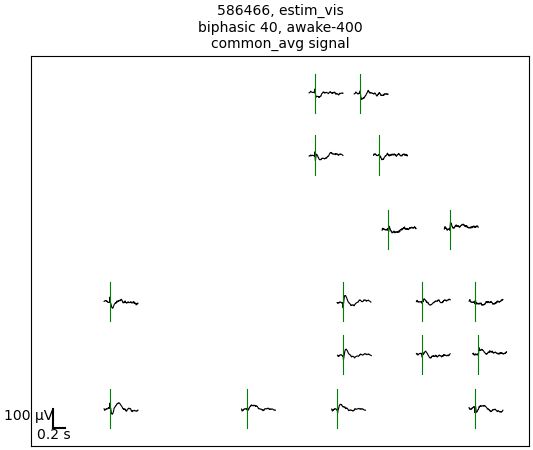

In [18]:
stim_type = 'biphasic'
parameter = '40'
plot_sweep = 0
signal_type = 'common_avg' # choose: 'raw', 'filtered', or 'common_avg'

prex = .1 # s before stim to plot
postx = .5 # s after stim to plot
xmult = 0.8
ymult = 250 # 250 for VEPs: 100

timex = avg_traces[stim_type][parameter][plot_sweep][signal_type][0]
plottraces = avg_traces[stim_type][parameter][plot_sweep][signal_type][1]
pinds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(16/3,9/2), constrained_layout=True)
# for chi in range(len(exp.EEG_channel_coordinates)):
for chi in GOOD_CHS:
    if chi in GOOD_CHS:
        trace_color = 'k'
    else:
        trace_color = 'r'
    ax.plot(
        timex[pinds] + (exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult),
        plottraces[pinds, chi] + (exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult),
        trace_color,
        linewidth=0.8
    )
    ax.plot([0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
             0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
            [-100+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
             100+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
            color='g', linewidth=0.8)
    if chi == 0:
        mx = timex[0] + exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult
        my = exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult

x_len = .2 # x scale bar length in ms
y_len = 100 # y scale bar length in uV, for VEP: 25
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} s'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')

ax.set_title('{}, {}\n{} {}, {}\n{} signal'.format(
    exp.mouse, exp_tag, stim_type, str(parameter), sweep_states[plot_sweep], signal_type
))
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

### SAVE ###
fig_name = '{}_{}CAR-ERP_array_{}{}{}.png'.format(exp_tag, signal_type, stim_type, str(parameter), sweep_states[plot_sweep])
fig.savefig(os.path.join(plotsavedir, fig_name), transparent=True)

<IPython.core.display.Javascript object>


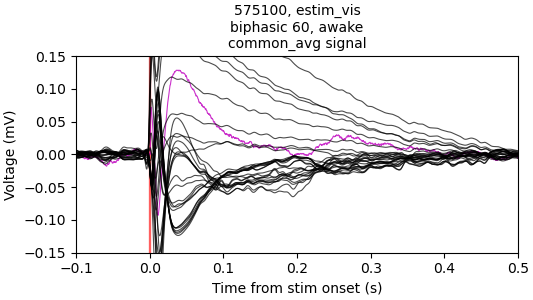

In [32]:
## Plot above but as butterfly ##
ylimit = 0.15 # mV, for visual 0.05, for estim 0.25

fig, ax = plt.subplots(figsize=(16/3,9/3), constrained_layout=True)
ax.plot(
    timex[pinds],
    np.mean(common_avg_ref[stim_type][parameter][plot_sweep][1], axis=1)[pinds]/1000,
    color='m', linewidth=0.8, alpha=0.8
)
for chi in GOOD_CHS:
    ax.plot(timex[pinds], plottraces[pinds, chi]/1000, color='k', linewidth=0.8, alpha=0.7)
ax.axvspan(-.001, .001, color='r', alpha=0.5)
# ax.axvspan(0., .25, color='g', alpha=0.1)

ax.set_xlim([-prex, postx])
ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}, {}\n{} {}, {}\n{} signal'.format(
    exp.mouse, exp_tag, stim_type, str(parameter), sweep_states[plot_sweep], signal_type
))

### SAVE ###
fig_name = '{}_{}CAR-ERP_butterfly_{}{}{}.png'.format(
    exp_tag, signal_type, stim_type, str(parameter), sweep_states[plot_sweep]
)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=True)

### Plot an event multiple sweeps

<IPython.core.display.Javascript object>


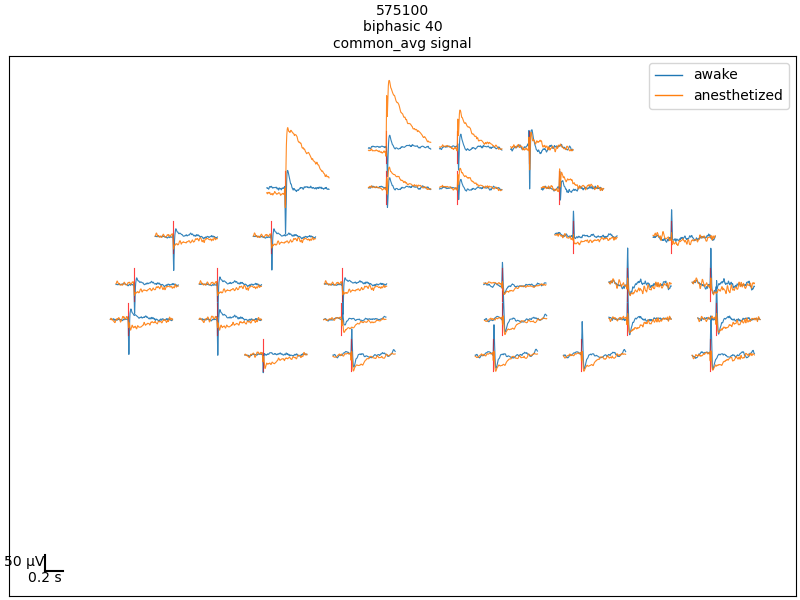

In [27]:
stim_type = 'biphasic'
parameter = '40'
sweeps = [0,1]
signal_type = 'common_avg' # choose: 'raw', 'filtered', or 'common_avg'
sweep_colors = {0: 'tab:blue', 1: 'tab:orange'}
# sweep_colors = {0: 'palegreen', 1: 'lawngreen', 2: 'green', 3: 'darkgreen'}
# sweep_colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'lime', 3: 'green'}

prex = .2 # s before stim to plot
postx = .5 # s after stim to plot
xmult = 0.8
ymult = 100 # 250 for VEPs: 100

fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
legend_entries = []
for sweepi in sweeps:
    timex = avg_traces[stim_type][parameter][sweepi][signal_type][0]
    plottraces = avg_traces[stim_type][parameter][sweepi][signal_type][1]
    pinds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

#     for chi in range(len(exp.EEG_channel_coordinates)):
    for chi in GOOD_CHS:
        ax.plot([0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
                 0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
                [-50+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
                 50+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
                color='r', linewidth=0.8, alpha=0.5)
        ax.plot(
            timex[pinds] + (exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult),
            plottraces[pinds, chi] + (exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult),
            color=sweep_colors[sweepi],
            linewidth=0.8,
            alpha=0.9
        )
        
#         ax.plot([0.25+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
#                 0.25+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
#                 [-25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
#                 25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
#                 color='g', linewidth=0.8)
        if chi == 0:
            mx = timex[0] + exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult
            my = exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult
    legend_entries.append(Line2D([0], [0], color=sweep_colors[sweepi], linewidth=1, label=sweep_states[sweepi]))

x_len = .2 # x scale bar length in ms
y_len = 50 # y scale bar length in uV
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} s'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')

ax.set_title('{}\n{} {}\n{} signal'.format(exp.mouse, stim_type, str(parameter), signal_type))
ax.legend(handles=legend_entries)#, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

### SAVE ###
fig_name = 'ERPs_{}_{}{}_awake_iso.png'.format(signal_type, stim_type, str(parameter))
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=True)

<IPython.core.display.Javascript object>


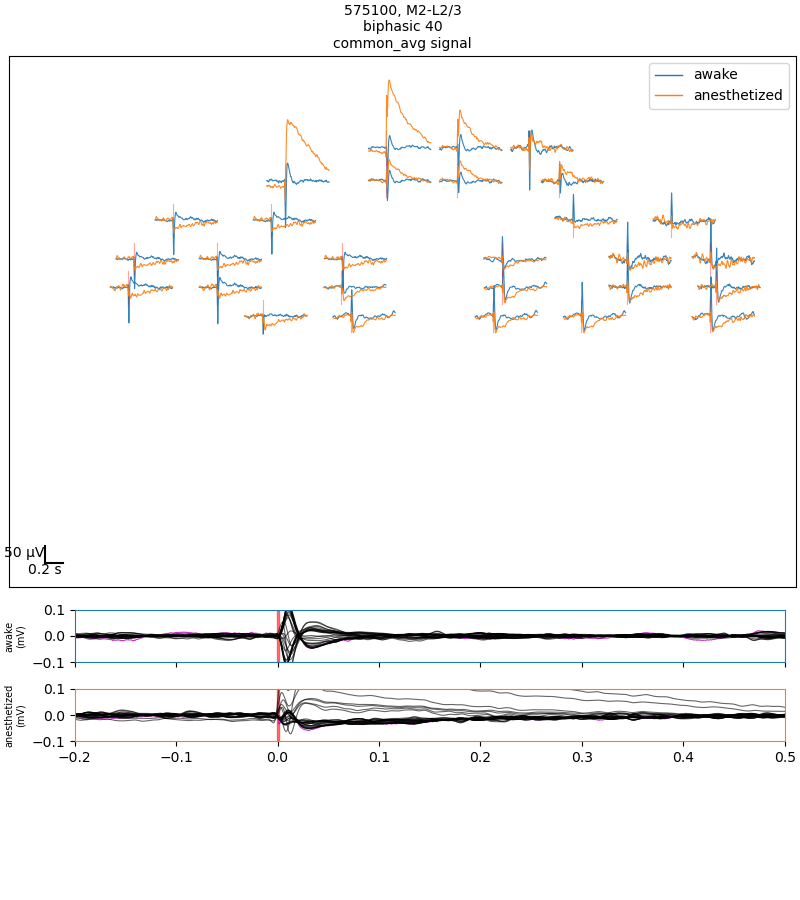

In [28]:
# stim_type = 'biphasic'
# parameter = 60
# sweeps = [3, 2]
# signal_type = 'common_avg' # choose: 'raw', 'filtered', or 'common_avg'
# sweep_colors = {3: 'tab:blue', 2: 'tab:orange'}

prex = .2 # s before stim to plot
postx = .5 # s after stim to plot
xmult = 0.8
ymult = 80 # 250 for VEPs: 100

yval = 0.1

fig = plt.figure(figsize=(16/2, 9), constrained_layout=True)
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[2,1])
axarray = fig.add_subplot(gs[0])
gsi = gs[1].subgridspec(ncols=1, nrows=4, hspace=0.1)

legend_entries = []
for ii, sweepi in enumerate(sweeps):
    timex = avg_traces[stim_type][parameter][sweepi][signal_type][0]
    plottraces = avg_traces[stim_type][parameter][sweepi][signal_type][1]
    pinds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

#     for chi in range(len(exp.EEG_channel_coordinates)):
    for chi in GOOD_CHS:
        axarray.plot([0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
                 0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
                [-50+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
                 50+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
                color='r', linewidth=0.8, alpha=0.2)
        axarray.plot(
            timex[pinds] + (exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult),
            plottraces[pinds, chi] + (exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult),
            color=sweep_colors[sweepi],
            linewidth=0.8,
            alpha=0.9
        )
        if chi == 0:
            mx = timex[0] + exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult
            my = exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult
    legend_entries.append(Line2D([0], [0], color=sweep_colors[sweepi], linewidth=1, label=sweep_states[sweepi]))
    
    ## plot butterfly traces ##
    axbf = fig.add_subplot(gsi[ii])
    axbf.axvspan(-.001, .001, color='r', alpha=0.5)
    axbf.plot(
        timex[pinds],
        -np.mean(common_avg_ref[stim_type][parameter][sweepi][1], axis=1)[pinds]/1000,
        color='m', linewidth=0.8, alpha=0.8
    )
    axbf.plot(timex[pinds], plottraces[pinds, :][:, GOOD_CHS]/1000, color='k', linewidth=0.8, alpha=0.6)
    axbf.set_xlim([-prex, postx])
    axbf.set_ylim([-yval, yval])
    axbf.spines['left'].set_color(sweep_colors[sweepi])
    axbf.spines['right'].set_color(sweep_colors[sweepi])
    axbf.spines['bottom'].set_color(sweep_colors[sweepi])
    axbf.spines['top'].set_color(sweep_colors[sweepi])
    axbf.set_ylabel('{}\n(mV)'.format(sweep_states[sweepi]), fontsize=7)
    if ii != len(sweeps)-1:
        axbf.set_xticklabels([])

x_len = .2 # x scale bar length in ms
y_len = 50 # y scale bar length in uV
axarray.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
axarray.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
axarray.annotate(('{} s'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
axarray.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')

axarray.set_title('{}, M2-L2/3\n{} {}\n{} signal'.format(exp.mouse, stim_type, str(parameter), signal_type))
axarray.legend(handles=legend_entries)#, bbox_to_anchor=(1.01, 1), loc='upper left')
axarray.tick_params(axis='x', bottom=False, labelbottom=False)
axarray.tick_params(axis='y', left=False, labelleft=False)

### SAVE ###
fig_name = '{}_{}ERP_combo_{}{}_M2l23.png'.format(exp_tag, signal_type, stim_type, str(parameter))
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=True)

Plot butterfly for one event

Butterfly plot, lines colored by distance from e-stim electrode

In [ ]:
stim_elec_AP = 1.4 # mm, with respect to bregma (pos is anterior)
stim_elec_ML = -1.2 # mm, with respect to bregma (neg is left hemi)

## ML in x position, AP in y ##
ch_coords = np.column_stack((EEGexp.EEG_channel_coordinates['ML'], EEGexp.EEG_channel_coordinates['AP']))
stim_elec_coords = np.array([stim_elec_ML, stim_elec_AP])

## Calculate the Euclidean distance to each electrode ##
ch_distances = np.linalg.norm(ch_coords - stim_elec_coords, axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)

dist_scatter = ax.scatter(EEGexp.EEG_channel_coordinates['ML'], EEGexp.EEG_channel_coordinates['AP'], c=ch_distances, s=300, cmap='rainbow')
ax.scatter(0, 0, marker='P', color='k')
ax.scatter(stim_elec_ML, stim_elec_AP, marker='*', color='k', s=150)
ax.axis('equal')
    
for ind in range(len(EEGexp.EEG_channel_coordinates)):
    ax.annotate(str(ind),  xy=(EEGexp.EEG_channel_coordinates['ML'].iloc[ind], EEGexp.EEG_channel_coordinates['AP'].iloc[ind]), ha='center', va='center', color="k")

cb = fig.colorbar(dist_scatter, ax=ax)
cb.set_label('Distance (mm)')
    
ax.set_xlabel('ML axis (mm)\nleft <--> right')
ax.set_ylabel('AP axis (mm)')
ax.set_title('Euclidean distance from stimulation site')

In [ ]:
pick_stim = 'biphasic'
pick_param = '50'
pick_sweep = 1
pick_traces = avg_filtered_traces # avg_traces or avg_filtered_traces

plot_name = 'rbbf_80ua_depth1200.png'

prex = 100 # ms before stim to plot
postx = 500 # ms after stim to plot
ylimit = 0.3 # mV

timex = pick_traces[pick_stim][pick_param][pick_sweep][0]
plottraces = pick_traces[pick_stim][pick_param][pick_sweep][1]/1000 # make them into mV
plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(16/3,9/4))

for chi in eeg_chs:
    ax.plot(timex[plot_inds], plottraces[plot_inds,chi], color=dist_scatter.to_rgba(ch_distances[chi]), linewidth=0.8)
    
ax.axvspan(-.001, .001, color='r', alpha=0.5)

ax.set_xlim([-prex, postx])
ax.set_ylim([-ylimit, ylimit])
# ax.set_xlabel('Time from stim onset (ms)')
# ax.set_ylabel('Voltage (mV)')
# ax.set_title('%s\n%s %s, sweep %d' % (exp.mouse, pick_stim, str(pick_param), pick_sweep))
# ax.set_xticklabels('')
ax.set_yticklabels('')

# cb = fig.colorbar(dist_scatter, ax=ax)
# cb.set_label('Distance (mm)')

## Save ##
# fig.savefig(os.path.join(plotsavedir, plot_name), transparent=True)

Plot all stim amps side by side

In [ ]:
len(avg_filtered_traces['biphasic'])

In [ ]:
pick_stim = 'biphasic'
pick_sweep = 0
pick_traces = avg_filtered_traces # avg_traces or avg_filtered_traces

plot_name = 'rbbf_allamps_awake.png'

prex = 100 # ms before stim to plot
postx = 500 # ms after stim to plot
ylimit = 0.3 # mV

fig, axs = plt.subplots(1, len(pick_traces[pick_stim]), sharex=True, sharey=True, figsize=(16,9/3), constrained_layout=True)
for ax, parami in zip(axs, pick_traces[pick_stim].keys()):
    timex = pick_traces[pick_stim][parami][pick_sweep][0]
    plottraces = pick_traces[pick_stim][parami][pick_sweep][1]/1000 # make them into mV
    plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

    for chi in eeg_chs:
        ax.plot(timex[plot_inds], plottraces[plot_inds,chi], color=dist_scatter.to_rgba(ch_distances[chi]), linewidth=0.8)

    ax.axvspan(-.001, .001, color='g', alpha=0.5)

    ax.set_xlim([-prex, postx])
    ax.set_ylim([-ylimit, ylimit])
#     ax.set_xlabel('Time from stim onset (s)')
    # ax.set_ylabel('Voltage (mV)')
    ax.set_title('{} \u03BCA stim'.format(str(parami)))
#     ax.set_xticklabels('')
#     ax.set_yticklabels('')

axs[0].set_ylabel('Voltage (mV)')
# cb = fig.colorbar(dist_scatter, ax=axs[2])
# cb.set_label('Distance (mm)')

## Save ##
# fig.savefig(os.path.join(plotsavedir, plot_name), transparent=True)

### Try spatial interpolation for EEG map of evoked responses

<IPython.core.display.Javascript object>


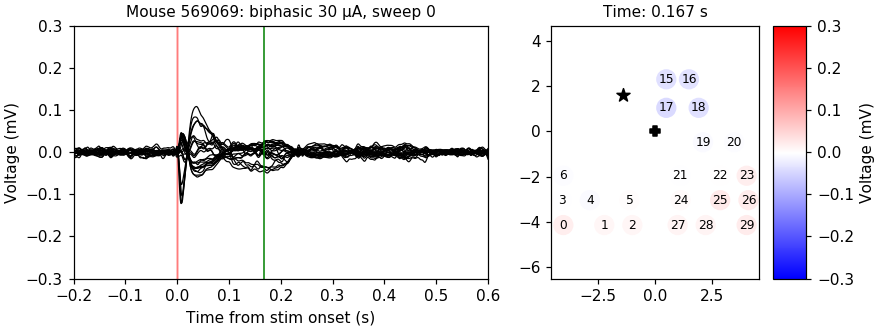

In [21]:
hm_time = 0.167
plot_window = [-0.2, 0.6]

stim = 'biphasic'
stimamp = 30
sweep = 0

vlim = 0.3

timex = comavg_traces[stim][stimamp][sweep][0]
traces = comavg_traces[stim][stimamp][sweep][1]/1000
GOOD_CHS = good_chs[stim][stimamp][sweep]
pinds = np.nonzero((timex >= plot_window[0]) & (timex <= plot_window[1]))[0]

fig = plt.figure(figsize=(8,3), constrained_layout=True)
gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2,1])

## butterfly plot ##
bfax = fig.add_subplot(gs[0])
bfax.plot(timex[pinds], traces[pinds,:][:,GOOD_CHS], 'k', linewidth=0.8)
bfax.axvspan(-0.001, 0.001, color='r', alpha=0.3)
bfax.axvline(hm_time, color='g', linewidth=1)
bfax.set_xlim(plot_window)
bfax.set_xlabel('Time from stim onset (s)')
bfax.set_ylim([-vlim, vlim])
bfax.set_ylabel('Voltage (mV)')
bfax.set_title('Mouse {}: {} {} \u03BCA, sweep {:d}'.format(exp.mouse, stim, stimamp, sweep))

## plot scatter plot heat map for time point ##
hmax = fig.add_subplot(gs[1])
timeinds = np.nonzero((timex >= hm_time - 0.0005) & (timex <= hm_time + 0.0005))[0]
ch_values = np.mean(traces[timeinds, :], axis=0)
hmsc = hmax.scatter(
    EEGexp.EEG_channel_coordinates['ML'][GOOD_CHS],
    EEGexp.EEG_channel_coordinates['AP'][GOOD_CHS],
    c=ch_values[GOOD_CHS],
    s=150,
    cmap='bwr',
    vmin=-vlim,
    vmax=vlim,
)
hmax.scatter(0, 0, marker='P', color='k')
hmax.scatter(-1.4, 1.6, marker='*', color='k', s=80)
hmax.axis('equal')
hmax.set_title('Time: {:.3f} s'.format(hm_time))

#     for ind in range(len(EEGexp.EEG_channel_coordinates)):
for ind in GOOD_CHS:
    hmax.annotate(
        str(ind),
        xy=(EEGexp.EEG_channel_coordinates['ML'].iloc[ind], EEGexp.EEG_channel_coordinates['AP'].iloc[ind]),
        ha='center', va='center', color='k', fontsize=8
    )
cb = fig.colorbar(hmsc, ax=hmax, fraction=0.01)
cb.set_label('Voltage (mV)')

## Save ##
# figname = 'bf_heatmap_{}{}.png'.format(state, stimamp)
# fig.savefig(os.path.join(plotsavedir, figname), transparent=True)

### Spectral analysis

Welch's method for whole recording

In [26]:
welchwinlen = 2 * exp.ephys_params['EEG']['sample_rate']
# nperseg = length of window, power of 2 is most efficient, 2**12 from Doug's notebook
# Signal Processing class uses 2 s window

In [27]:
frex, Pxx = signal.welch(eeg_data, exp.ephys_params['EEG']['sample_rate'], nperseg=welchwinlen, axis=0)

<IPython.core.display.Javascript object>


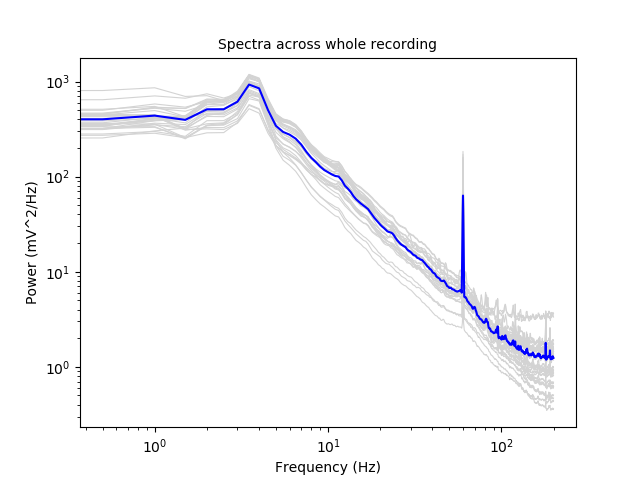

Text(0.5, 1.0, 'Spectra across whole recording')

In [28]:
frinds = frex < 200

fig, ax = plt.subplots()

ax.loglog(frex[frinds], Pxx[frinds,:], color='lightgray', linewidth=0.8)
ax.loglog(frex[frinds], np.mean(Pxx, axis=1)[frinds], color='b', linewidth=1.5)
# ax.loglog(fa[frinds], np.mean(Pxx_dena, axis=1)[frinds], color=ancolor, linewidth=2, label=('Anesthetized'))

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra across whole recording')
# ax.legend()

Welch's method for evoked responses

In [20]:
pick_stim = 'biphasic'
pick_param = '35'
pick_sweep = 0
pick_traces = avg_traces # avg_traces or avg_filtered_traces

timex = pick_traces[pick_stim][pick_param][pick_sweep][0]
Wfilttraces = pick_traces[pick_stim][pick_param][pick_sweep][1]/1000 # make them into mV

In [21]:
welchwinlen = 1 * exp.ephys_params['EEG']['sample_rate']
# nperseg = length of window, power of 2 is most efficient, 2**12 from Doug's notebook
# Signal Processing class uses 2 s window

In [22]:
frex, Pxx = signal.welch(Wfilttraces, exp.ephys_params['EEG']['sample_rate'], nperseg=welchwinlen, axis=0)

<IPython.core.display.Javascript object>


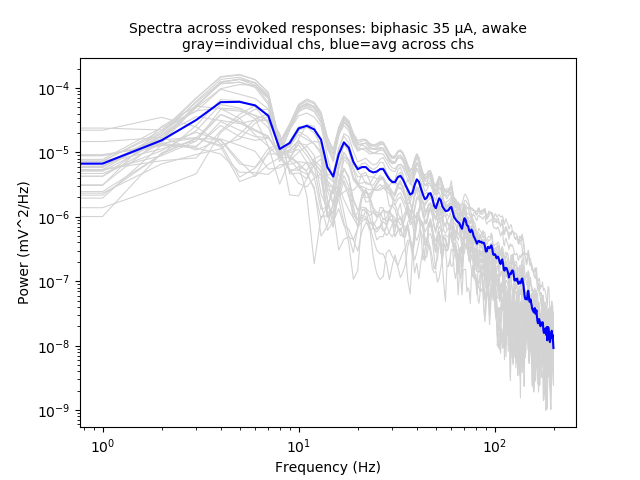

Text(0.5, 1.0, 'Spectra across evoked responses: biphasic 35 μA, awake\ngray=individual chs, blue=avg across chs')

In [23]:
frinds = frex < 200

fig, ax = plt.subplots()

ax.loglog(frex[frinds], Pxx[frinds,:], color='lightgray', linewidth=0.8)
ax.loglog(frex[frinds], np.mean(Pxx, axis=1)[frinds], color='b', linewidth=1.5)
# ax.loglog(fa[frinds], np.mean(Pxx_dena, axis=1)[frinds], color=ancolor, linewidth=2, label=('Anesthetized'))

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra across evoked responses: {} {} \u03BCA, awake\ngray=individual chs, blue=avg across chs'.format(pick_stim, pick_param))
# ax.legend()

Spectrogram for one ch over time

In [49]:
frex, time, pwr = signal.spectrogram(eeg_data[:,5], exp.ephys_params['EEG']['sample_rate'])

In [53]:
frinds = frex < 100
pwr_frinds = pwr[frinds,:]

In [54]:
print(np.min(pwr_frinds))
print(np.max(pwr_frinds))

2.674642291916434e-10
472496.72388749215


<IPython.core.display.Javascript object>


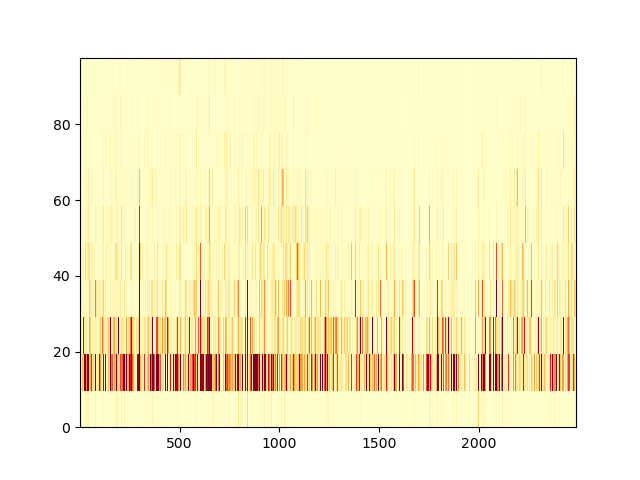

In [56]:
fig, ax = plt.subplots()
ax.pcolormesh(time, frex[frinds], pwr_frinds, cmap='YlOrRd', vmin=0, vmax=100)

### Design a bandpass filter for the traces

In [ ]:
lower_bound = 0.5 # Hz

HPforder = int(1 * exp.ephys_params['EEG']['sample_rate'] / lower_bound) + 1
print(HPforder)

HPfiltkern = signal.firwin(HPforder, lower_bound, fs=exp.ephys_params['EEG']['sample_rate'], pass_zero=False)

In [ ]:
## Plot spectrum of kernel to check ##
hz = np.linspace(0, exp.ephys_params['EEG']['sample_rate']/2, int(np.floor(len(HPfiltkern)/2)+1))
HPfilterpow = np.abs(fftpack.fft(HPfiltkern))**2

fig, ax = plt.subplots()
ax.plot(hz, HPfilterpow[:len(hz)],'k')

In [ ]:
plot_traces.shape

In [ ]:
upper_bound = 100 # Hz

LPforder = 20 * int(exp.ephys_params['EEG']['sample_rate'] / upper_bound) + 1
print(LPforder)

LPfiltkern = signal.firwin(LPforder, upper_bound, fs=exp.ephys_params['EEG']['sample_rate'], pass_zero=True)

In [ ]:
## Plot spectrum of kernel to check ##
hz = np.linspace(0, exp.ephys_params['EEG']['sample_rate']/2, int(np.floor(len(LPfiltkern)/2)+1))
LPfilterpow = np.abs(fftpack.fft(LPfiltkern))**2

fig, ax = plt.subplots()
ax.plot(hz, LPfilterpow[:len(hz)], 'r')
ax.plot([lower_bound, lower_bound], [0,1], 'b--')
ax.plot([upper_bound, upper_bound], [0,1], 'b--')
ax.set_xlim([0, upper_bound*2])

Apply the band-pass filter, high- then low-pass.

In [ ]:
pick_stim = 'biphasic'
pick_param = '50'
pick_sweep = 2
pick_traces = traces # start with individual traces

prex = 500 # ms before stim to plot
postx = 500 # ms after stim to plot
ylimit = 0.3 # mV

timex = pick_traces[pick_stim][pick_param][pick_sweep][0]
plot_traces = pick_traces[pick_stim][pick_param][pick_sweep][1]/1000 # make them into mV
plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

## Apply filters ##
filt_traces = signal.filtfilt(HPfiltkern, 1, plot_traces, axis=0)
filt_traces = signal.filtfilt(LPfiltkern, 1, filt_traces, axis=0)
mean_filtered = np.mean(filt_traces, axis=2)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(timex[plot_inds], mean_filtered[plot_inds,:], color='k', linewidth=0.6)
ax.axvspan(-1, 1, color='r', alpha=0.5)

ax.set_xlim([-prex, postx])
ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (ms)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}, sweep {:d}'.format(exp.mouse, pick_stim, str(pick_param), pick_sweep))

### Quantify responses to different amplitudes

In [19]:
comp_states = sweep_states # {0: 'awake1', 1: 'awake2', 2: 'awake3', 3: 'awake4'}
# AUC_window = {'500_ms': [0.005, 0.5], 'first_100_ms': [0.005, 0.105], 'second_100_ms': [0.1, 0.2]}
AUC_window = [0.005, 0.5] # [0.1, 0.2]
PCI_params = {
    'baseline_window': (-0.8, -0.005), # s before stim for baseline, my default: (-500, -1)
    'response_window': (0.005, 0.8), # s after stim for response, my default: (1, 500)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}

AUC_list = []
state_list = []
amp_list = []
ch_list = []
PCI_list = []
nPCs_list = []
PCIstate_list = []
PCIamp_list = []
final_traces = {}
for ampi, sweepdict in avg_traces['biphasic'].items():
    final_traces[ampi] = {}
    
#     NUM_TRIALS = min([sweepdict[x][1].shape[2] for x in comp_states.keys()])
    
    for sweepi, statei in comp_states.items():
        timex = sweepdict[sweepi]['common_avg'][0]
#         mean_data = np.mean(sweepdict[sweepi][1][:, :, :NUM_TRIALS], axis=2)
        mean_data = sweepdict[sweepi]['common_avg'][1]
        final_traces[ampi][sweepi] = [timex, mean_data, GOOD_CHS]
        
        ## calculate AUC in window ##
        preinds = np.nonzero((timex >= -AUC_window[1]) & (timex <= -AUC_window[0]))[0]
        baseline_auc = integrate.simps(np.abs(mean_data[preinds, :]), timex[preinds], axis=0, even='last')
        postinds = np.nonzero((timex >= AUC_window[0]) & (timex <= AUC_window[1]))[0]
        response_auc = integrate.simps(np.abs(mean_data[postinds, :]), timex[postinds], axis=0, even='last')

        AUC_list.append(response_auc[GOOD_CHS] - baseline_auc[GOOD_CHS])
        state_list.append([statei] * GOOD_CHS.shape[0])
        amp_list.append([ampi] * GOOD_CHS.shape[0])
        ch_list.append(GOOD_CHS)
        
        ## calculate PCI ##
        full_PCI_output = calc_PCIst(
            mean_data[:, GOOD_CHS].T,
            timex,
            full_return=True,
            **PCI_params
        )
        PCI_list.append(full_PCI_output['PCI'])
        nPCs_list.append(full_PCI_output['n_dims'])
        PCIstate_list.append(statei)
        PCIamp_list.append(ampi)

AUC_df = pd.DataFrame({
    'response_mag': np.concatenate(AUC_list),
    'electrode': np.concatenate(ch_list),
    'stim_amp': np.concatenate(amp_list),
    'state': np.concatenate(state_list)
})
PCI_df = pd.DataFrame({
    'PCI': PCI_list,
    'num_PCs': nPCs_list,
    'stim_amp': PCIamp_list,
    'state': PCIstate_list
})

In [20]:
PCI_df

,PCI,num_PCs,stim_amp,state
0,0.000000,0,20,awake-400
1,45.095781,5,20,awake-900
2,6.962859,1,20,anesthetized-900
3,0.000000,0,20,anesthetized-400
4,19.880903,3,40,awake-400
5,68.729453,6,40,awake-900
6,19.912702,3,40,anesthetized-900
7,16.894770,2,40,anesthetized-400
8,19.454377,3,60,awake-400
9,67.463530,6,60,awake-900


<IPython.core.display.Javascript object>


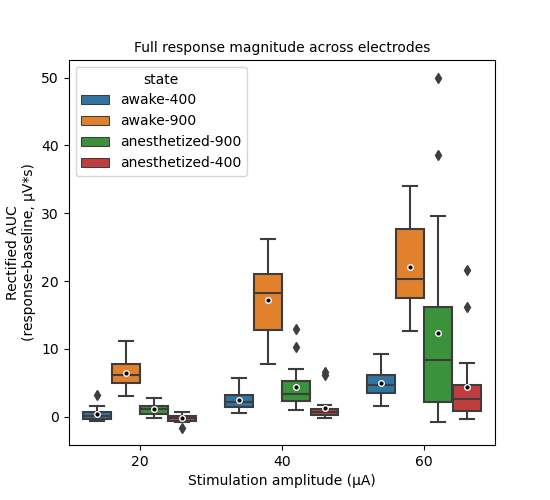

Text(0.5, 1.0, 'Full response magnitude across electrodes')

In [21]:
## Box plot for AUC ##
fig, ax = plt.subplots(figsize=(5.5,5))
bxplt = sns.boxplot(
    x='stim_amp',
    y='response_mag',
    hue='state',
    data=AUC_df,
    ax=ax,
    showmeans=True,
    meanprops={'marker':'.', 'markerfacecolor':'black', 'markeredgecolor':'white', 'markersize':'8'}
)
bxplt.set_xlabel('Stimulation amplitude (\u03BCA)')
bxplt.set_ylabel('Rectified AUC\n(response-baseline, \u03BCV*s)')
bxplt.set_title('Full response magnitude across electrodes')

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'Response5-500ms_AUC_goodchs.png'), transparent=True)

<IPython.core.display.Javascript object>


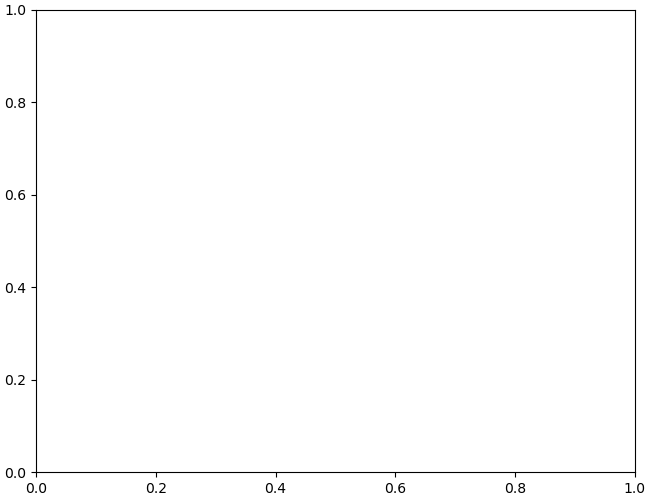

NameError: name 'sweep_colors' is not defined

In [22]:
## Bar plot for PCI ##
fig, ax = plt.subplots(figsize=(6.5,5), constrained_layout=True)
cplt = sns.barplot(
    x='stim_amp',
    y='PCI',
    hue='state',
    data=PCI_df,
    ax=ax,
    palette=list(sweep_colors.values())
)
cplt.set_xlabel('Stimulation amplitude (\u03BCA)')
cplt.set_ylabel('$\mathregular{PCI^{ST}}$')
cplt.set_ylim([0,60])
cplt.set_title('PCI (awake control)')
cplt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Save ##
figname = '{}_PCI_allamps_awakecont.png'.format(exp_tag)
# fig.savefig(os.path.join(plotsavedir, figname), transparent=True)

<IPython.core.display.Javascript object>


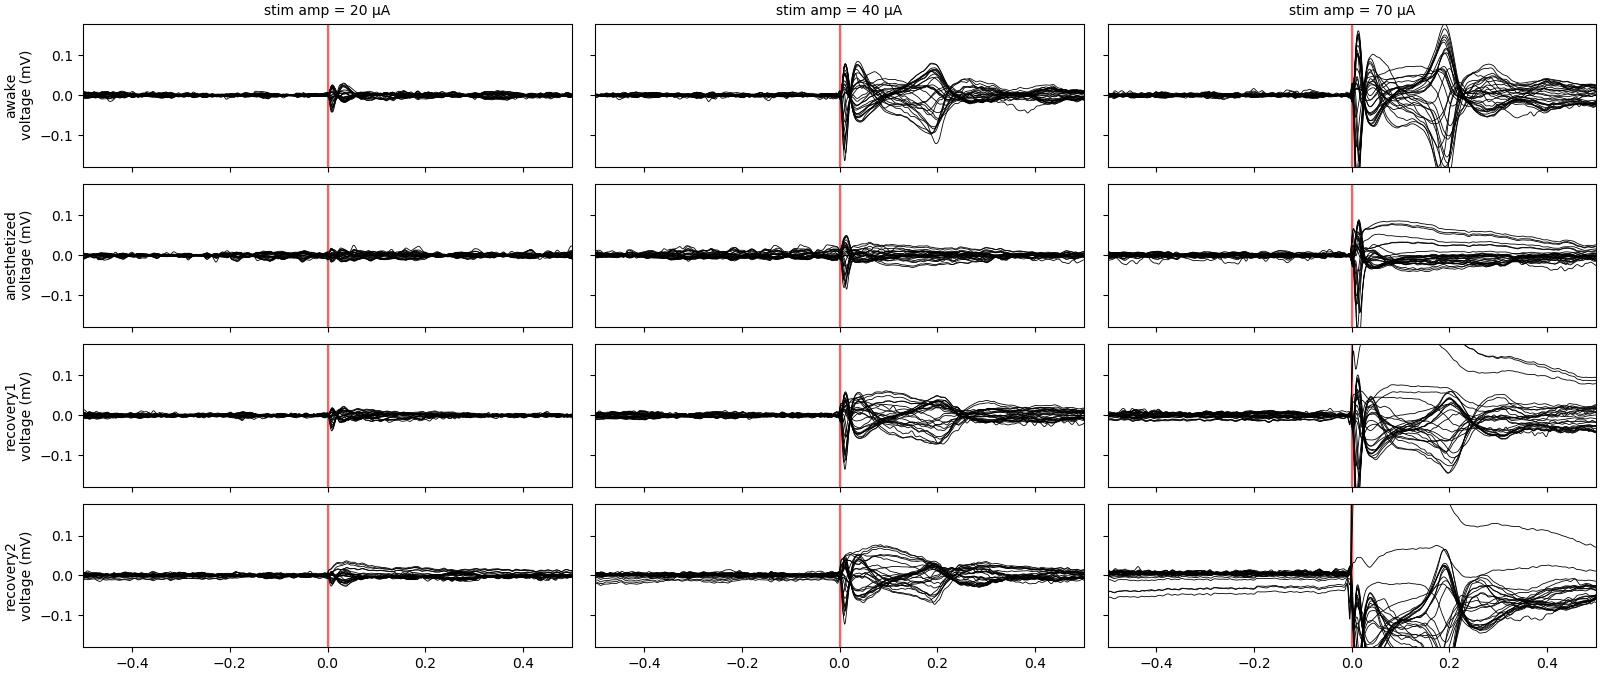

In [33]:
prex = .5 # ms before stim to plot
postx = .5 # ms after stim to plot
ylimit = 0.18 # mV

fig, axs = plt.subplots(len(comp_states.keys()), len(final_traces.keys()), figsize=(16,9*0.75), sharex=True, sharey=True, constrained_layout=True)
for sweepi, statei in comp_states.items():
    for col, parami in enumerate(final_traces.keys()):
        timex = final_traces[parami][sweepi][0]
        plottraces = final_traces[parami][sweepi][1][:, final_traces[parami][sweepi][2]]/1000 # make them into mV
        plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

        axs[sweepi,col].plot(timex[plot_inds], plottraces[plot_inds,:], color='k', linewidth=0.6)
        axs[sweepi,col].axvspan(-.001, .001, color='r', alpha=0.5)
        
        if col == 0:
            axs[sweepi,col].set_ylabel('{:s}\nvoltage (mV)'.format(statei))
        if sweepi == 0:
            axs[sweepi,col].set_title('stim amp = {:s} \u03BCA'.format(parami))

axs[0,0].set_xlim([-prex, postx])
axs[0,0].set_ylim([-ylimit, ylimit])

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'estim_EEG_allamps_states_isoexp.png'), transparent=True)

### Plot EEG traces with unit activity

In [118]:
plot_probe = 'probeC'

select_units, peak_chs, unit_metrics = exp.get_probe_units(plot_probe)
sorted_units = select_units[np.squeeze(np.argsort(peak_chs))]
sorted_peak_chs = peak_chs[np.squeeze(np.argsort(peak_chs))]
print(len(sorted_units))

spike_times = np.load(exp.ephys_params[plot_probe]['spike_times'])
spike_clusters = np.load(exp.ephys_params[plot_probe]['spike_clusters'])

99


In [119]:
with open(exp.ephys_params[plot_probe]['probe_info']) as data_file:
    data = json.load(data_file)
npx_allch = np.array(data['channel']) # this is an array from 0 to 384
surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
allch_z = np.array(data['vertical_pos']) # vertical position of each electrode (um), relative to the tip (ch 0 is 20 um from tip)
ref_mask = np.array(data['mask']) # contains a False for Npx reference channels
print('{} brain surface channel: {:d}'.format(plot_probe, surface_ch))

npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch]) 
all_ch_depths = allch_z[surface_ch] - allch_z

probeC brain surface channel: 300


In [120]:
unit_depths = np.array([npx_ch_depths[np.squeeze(np.argwhere(npx_chs==x))] if x <= surface_ch else 0 for x in sorted_peak_chs])
unit_1mm = np.squeeze(np.argwhere(unit_depths <= 1500))
print(unit_1mm[0])

64


In [34]:
# plot_before = 1.0 # time before event, s
# plot_after = 1.0 # time after event, s
plot_timebin = 0.005 # s

## Loop through all stim events/sweeps and collect evoked firing rates
unit_firing_rate = {}
unit_zscore = {}
for st_type in stim_log.stim_type.unique():
    unit_firing_rate[st_type] = {}
    unit_zscore[st_type] = {}
    
    param_list = np.sort(stim_log[stim_log['stim_type']==st_type].parameter.unique())
    for parami in param_list:
        unit_firing_rate[st_type][parami] = {}
        unit_zscore[st_type][parami] = {}
        
        sweep_list = np.sort(stim_log[(stim_log['stim_type']==st_type) & (stim_log['parameter']==parami)].sweep.unique())
        for sweepi in sweep_list:
            print('{}, {} \u03BCA, sweep {:d}'.format(st_type, str(parami), sweepi))
            ## Get event times ##
            events = get_stim_events(stim_log, st_type, parami, sweepi)
            if len(events) == 0:
                print('no good trials found')
                continue
            
            ## Get event firing rate ##
            event_trig_FR, FR_timestamps = get_evoked_firing_rates(
                spike_times,
                spike_clusters,
                sorted_units,
                events,
                plot_before,
                plot_after,
                plot_timebin
            )
            
            event_trig_Z, non_nan_inds = get_zscore_fr(event_trig_FR, FR_timestamps)
            
            ## Store traces ##
            unit_firing_rate[st_type][parami][sweepi] = [FR_timestamps, event_trig_FR]
            unit_zscore[st_type][parami][sweepi] = [FR_timestamps, event_trig_Z]

biphasic, 50 μA, sweep 0
biphasic, 50 μA, sweep 1
biphasic, 50 μA, sweep 2
biphasic, 50 μA, sweep 3
biphasic, 70 μA, sweep 0
biphasic, 70 μA, sweep 1
biphasic, 70 μA, sweep 2
biphasic, 70 μA, sweep 3
biphasic, 90 μA, sweep 0
biphasic, 90 μA, sweep 1
biphasic, 90 μA, sweep 2
biphasic, 90 μA, sweep 3
fullscreen, white μA, sweep 0
fullscreen, white μA, sweep 1
fullscreen, white μA, sweep 2


<IPython.core.display.Javascript object>


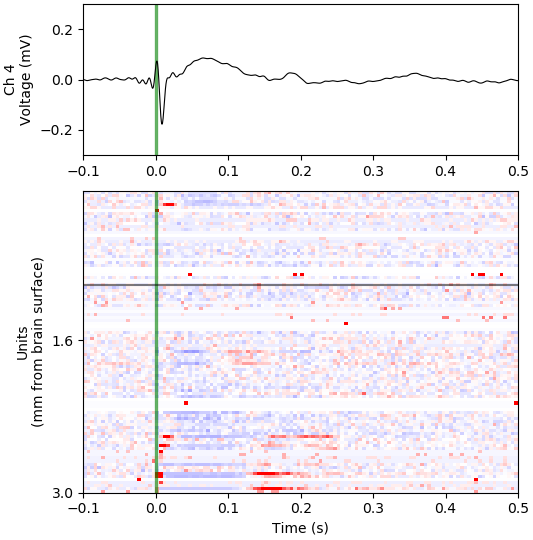

In [35]:
## Plot z-score and EEG ##
pick_stim = 'biphasic'
pick_param = '90'
pick_sweep = 0
pick_traces = avg_filtered_traces # avg_traces or avg_filtered_traces
plot_ch = 4
plot_name = '{:s}_iso_{:s}_eeg_zscore.png'.format(plot_probe, pick_param)

prex = 0.1 # s before stim to plot
postx = 0.5 # s after stim to plot
ylimit = 0.3 # mV
ylabel_depth = True

fig = plt.figure(figsize=(16/3,9*0.6), constrained_layout=True)
gs = fig.add_gridspec(3, 1)

eegax = fig.add_subplot(gs[0, :])
unitax = fig.add_subplot(gs[1:, :], sharex=eegax)

## Plot eeg traces ##
timex = pick_traces[pick_stim][pick_param][pick_sweep][0]
plottraces = pick_traces[pick_stim][pick_param][pick_sweep][1]/1000 # make them into mV
eeg_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

eegax.plot(timex[eeg_inds], plottraces[eeg_inds,plot_ch], color='k', linewidth=0.8)
eegax.axvspan(-.001, .001, color='g', alpha=0.5)
eegax.set_xlim([-prex, postx])
eegax.set_ylim([-ylimit, ylimit])
eegax.set_ylabel('Ch {:d}\nVoltage (mV)'.format(plot_ch))
# ax.set_title('%s\n%s %s, sweep %d' % (exp.mouse, pick_stim, str(pick_param), pick_sweep))
# eegax.set_xticklabels('')

## Plot z-scores ##
unit_inds = np.squeeze(np.argwhere((unit_firing_rate[pick_stim][pick_param][pick_sweep][0] >= -prex) & (unit_firing_rate[pick_stim][pick_param][pick_sweep][0] <= postx)))
FR_plot = unitax.imshow(
    unit_zscore[pick_stim][pick_param][pick_sweep][1][:, unit_inds],
    cmap='bwr',
    interpolation='none',
    aspect='auto',
    origin='lower',
    vmin=-10,
    vmax=10,
    extent=[-prex, postx, 0, len(sorted_units)],
#     extent=[unit_firing_rate[pick_stim][pick_param][pick_sweep][0][0], unit_firing_rate[pick_stim][pick_param][pick_sweep][0][-1], 0, len(sorted_units)],
)

## X labels
unitax.set_xlabel('Time (s)')
unitax.axvspan(-.001, .001, color='g', alpha=0.5)

## Y labels
if ylabel_depth:
    unitax.set_yticks(np.arange(0, len(sorted_units), 50))
    unitax.set_yticklabels(all_ch_depths[sorted_peak_chs[np.arange(0, len(sorted_units), 50)]]/1000)
    unitax.set_ylabel('Units\n(mm from brain surface)')
    unitax.axhline(unit_1mm[0], color='k', alpha=0.5)
else:
    unitax.set_ylabel('Units\ndeep <---> superficial')
    
## Color bar
# cbar = plt.colorbar(FR_plot, ax=unitax)
# cbar.set_label('z-score', fontsize=10)
# cbar.ax.tick_params(labelsize=10)

## Save ##
# fig.savefig(os.path.join(plotsavedir, plot_name), transparent=True)

<IPython.core.display.Javascript object>


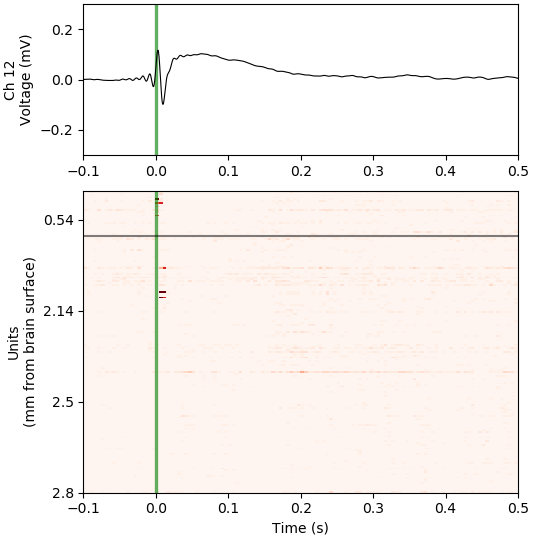

In [62]:
## Plot firing rate and EEG ##
pick_stim = 'biphasic'
pick_param = '90'
pick_sweep = 1
pick_traces = avg_filtered_traces # avg_traces or avg_filtered_traces
plot_ch = 12
plot_name = '{:s}_iso_{:s}_eeg_firingrate.png'.format(plot_probe, pick_param)

prex = 0.1 # s before stim to plot
postx = 0.5 # s after stim to plot
ylimit = 0.3 # mV
ylabel_depth = True

fig = plt.figure(figsize=(16/3,9*0.6), constrained_layout=True)
gs = fig.add_gridspec(3, 1)

eegax = fig.add_subplot(gs[0, :])
unitax = fig.add_subplot(gs[1:, :], sharex=eegax)

## Plot eeg traces ##
timex = pick_traces[pick_stim][pick_param][pick_sweep][0]
plottraces = pick_traces[pick_stim][pick_param][pick_sweep][1]/1000 # make them into mV
eeg_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

eegax.plot(timex[eeg_inds], plottraces[eeg_inds,plot_ch], color='k', linewidth=0.8)
eegax.axvspan(-.001, .001, color='g', alpha=0.5)
eegax.set_xlim([-prex, postx])
eegax.set_ylim([-ylimit, ylimit])
eegax.set_ylabel('Ch {:d}\nVoltage (mV)'.format(plot_ch))
# ax.set_title('%s\n%s %s, sweep %d' % (exp.mouse, pick_stim, str(pick_param), pick_sweep))
# eegax.set_xticklabels('')

## Plot z-scores ##
unit_inds = np.squeeze(np.argwhere((unit_firing_rate[pick_stim][pick_param][pick_sweep][0] >= -prex) & (unit_firing_rate[pick_stim][pick_param][pick_sweep][0] <= postx)))
FR_plot = unitax.imshow(
    unit_firing_rate[pick_stim][pick_param][pick_sweep][1][:, unit_inds],
    cmap='Reds',
    interpolation='none',
    aspect='auto',
    origin='lower',
    vmin=0,
    vmax=50,
    extent=[-prex, postx, 0, len(sorted_units)],
#     extent=[unit_firing_rate[pick_stim][pick_param][pick_sweep][0][0], unit_firing_rate[pick_stim][pick_param][pick_sweep][0][-1], 0, len(sorted_units)],
)

## X labels
unitax.set_xlabel('Time (s)')
unitax.axvspan(-.001, .001, color='g', alpha=0.5)

## Y labels
if ylabel_depth:
    unitax.set_yticks(np.arange(0, len(sorted_units), 50))
    unitax.set_yticklabels(all_ch_depths[sorted_peak_chs[np.arange(0, len(sorted_units), 50)]]/1000)
    unitax.set_ylabel('Units\n(mm from brain surface)')
    unitax.axhline(unit_1mm[0], color='k', alpha=0.5)
else:
    unitax.set_ylabel('Units\ndeep <---> superficial')
    
## Color bar
# cbar = plt.colorbar(FR_plot, ax=unitax)
# cbar.set_label('firing rate (Hz)', fontsize=10)
# cbar.ax.tick_params(labelsize=10)

## Save ##
# fig.savefig(os.path.join(plotsavedir, plot_name), transparent=True)

#### Plot single trial rasters

In [125]:
pick_stim = 'biphasic'
pick_param = '90'
pick_sweep = 0
event_num = 7
prex = 0.1 # s before stim to plot
postx = 0.5 # s after stim to plot

raster_time = get_stim_events(stim_log, pick_stim, pick_param, pick_sweep)[event_num]
units_raster = []
for uniti in sorted_units:
    spikesi = np.squeeze(spike_times[spike_clusters == uniti]) # this will give you all the spikes that belong to one unit

    spikei_inds = np.squeeze(np.argwhere((spikesi > raster_time-prex) & (spikesi < raster_time+postx)))
    units_raster.append(spikesi[spikei_inds]-raster_time)

<IPython.core.display.Javascript object>


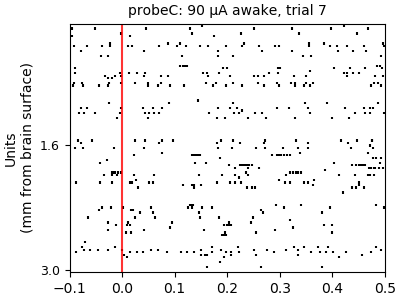

In [126]:
turn_on_xlabels = True
ylabel_depth = True

fig, ax = plt.subplots(figsize=(16/4,9/3), constrained_layout=True) # figsize=(5,2.5)
for indi, spikes in enumerate(units_raster):
    ax.eventplot([spikes], lineoffsets=indi, linelengths=0.95, color='black')
ax.set_xlim([-prex, postx])
ax.set_ylim([-1, indi+1])

## Y labels
if ylabel_depth:
    ax.set_yticks(np.arange(0, len(sorted_units), 50))
    ax.set_yticklabels(all_ch_depths[sorted_peak_chs[np.arange(0, len(sorted_units), 50)]]/1000, fontsize=9)
    ax.set_ylabel('Units\n(mm from brain surface)')
else:
    ax.set_ylabel('Units\ndeep <---> superficial')

## X labels
ax.axvline(0, color='r', alpha=0.8)
# if turn_on_xlabels:
#     if plot_event == 'stim':
#         ax.set_xticks(np.arange(raster_time-prex, raster_time+postx, 0.25))
#         ax.set_xticklabels(np.arange(-prex, postx, 0.25), fontsize=8)
#     ax.tick_params(axis='x', labelsize=8)
#     ax.set_xlabel('Time (s)', fontsize=8)
# else:
#     plt.tick_params(axis='x', labelbottom=False)

ax.set_title('{}: {} \u03BCA awake, trial {:d}'.format(plot_probe, pick_param, event_num))

## Save ##
plot_name = '{}raster_awake{}_trial{:d}.png'.format(plot_probe, pick_param, event_num)
# fig.savefig(os.path.join(plotsavedir, plot_name), transparent=True)